## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi
from math import sqrt
from skimage import morphology
from skimage.morphology import opening
from skimage import transform
from skimage import filters

## Paths

In [2]:
IMG_PATH = '../data/example_image/'
SUPER_IMG_PATH = '../data/example_image/'
SEG_PATH = '../data/example_segmentation/'

TRUTH = '../data/example_ground_truth.csv'
FEATURES = '../features/features.csv'

## Functions

In [3]:
def rgb2gray(circle_reference):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray


def mask(image, sens):
    '''takes path to .jpg and returns a masked image'''
    img =  image
    #also want to be able to crop the image automaticallty here
    gray = rgb2gray(img) #create grayscale thingy
    img2 = gray < sens # **This level needs manually adjusting, also need to be able to automate**
    
    return img2

def dimensions(mask):
    '''calculates height(max) and width(90 deg to height)
        returns height, width, rotated mask image, degree of rotation'''
    pixels_in_col = np.max(np.sum(mask, axis=0))

    rot = 0
    max_col = 0
    rot_max = 0
    for _ in range(9):
        rot_im = transform.rotate(mask,rot)
        pixels_in_col = np.max(np.sum(rot_im, axis=0))
        if pixels_in_col > max_col:
            max_col = pixels_in_col
            rot_max = rot
        rot += 10

    pixels_in_row = np.max(np.sum(mask1, axis=1))    
    return max_col, pixels_in_row, rot_max

def perimeter(bi_image):
    '''calcs mask perimeter, returns outline image and length of perimeter'''
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(bi_image, struct_el)
    image_perimeter = bi_image - mask_eroded

    return image_perimeter, float(np.sum(image_perimeter))

def predict(bi_image):   
    area = np.sum(bi_image)
    _, peri = perimeter(bi_image)
    
    area_from_peri = pi*((peri/(2*pi))**2)
    peri_from_area = 2*pi*sqrt(area/pi)
    
    return area, area_from_peri, peri, peri_from_area

## Import single image and create mask

(1020, 1187, 3)
(1020, 1187)


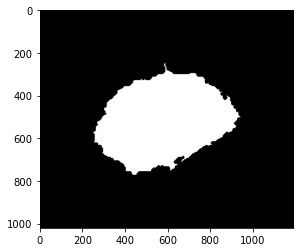

In [4]:
IMG = 'ISIC_0001769'
image = plt.imread(IMG_PATH+IMG+'.jpg')
mask1 = plt.imread(SEG_PATH+IMG+'_segmentation.png')

plt.imshow(mask1, cmap='gray');

mask = np.where(mask1 == 1)

x_min = min(mask[0])
if x_min > 250:
    x_min -= 250
else:
    x_min = 0
y_min = min(mask[1])
if y_min > 250:
    y_min -= 250
else:
    y_min = 0
    
x_max = max(mask[0])+250
y_max = max(mask[1])+250




image = image[x_min:x_max,y_min:y_max]
mask1 = mask1[x_min:x_max,y_min:y_max]


print(image.shape)
print(mask1.shape)

plt.imshow(mask1, cmap='gray');

1210740 216160.0
17.85354411351735


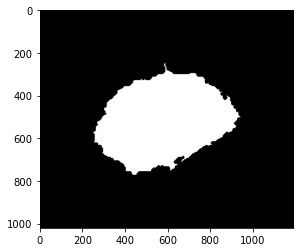

In [5]:
#Total size of the image
total = mask1.shape[0] * mask1.shape[1] 

#Size of mask only
area = np.sum(mask1)
print(total, area)
#As percentage
print(area/total*100)

plt.imshow(mask1, cmap='gray');

Height: 693.40, 
Width: 655.00


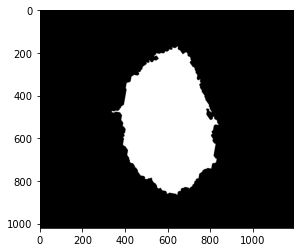

In [6]:
height, width, rot_max = dimensions(mask1)
rot_img = transform.rotate(mask1,rot_max)
print(f'Height: {height:.2f}, \nWidth: {width:.2f}')
plt.imshow(rot_img, cmap='gray');

Length: 2013.00


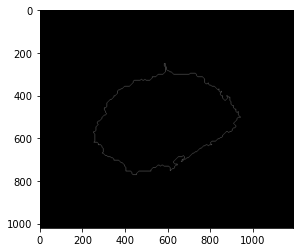

In [7]:
peri_img, peri = perimeter(mask1)

print(f'Length: {peri:.2f}')

plt.imshow(peri_img, cmap='gray');

In [8]:
rad_from_peri = peri/(2*pi)
rad_from_area = sqrt(area/pi)

est_circ = 2*pi*rad_from_area
est_area = pi*rad_from_peri**2

print(f'Difference in circumference: {abs(peri-est_circ):.2f} \nDifference in area: {abs(area-est_area):.2f}')

Difference in circumference: 364.87 
Difference in area: 106301.36


In [9]:
print(predict(mask1))

(216160.0, 322461.3632968713, 2013.0, 1648.1343003529412)


## Load dataframes

In [10]:
truth = pd.read_csv(TRUTH)
truth.head()


,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0


In [11]:
cancer = truth[truth['melanoma'] == 1]
cancer.shape

(30, 3)

In [13]:
pred_df = pd.DataFrame(columns=['id', 'area', 'pred_area', 'peri','pred_peri','melanoma'])

c=0
for name in truth['image_id']:
    mask1 = plt.imread(SEG_PATH+name+'_segmentation.png')
    area, pred_area, peri, pred_peri = predict(mask1)
    pred_df.loc[c] = [name, area, pred_area, peri, pred_peri,truth[truth['image_id'] == name].iloc[0]['melanoma']]
    c+=1


In [14]:
pred_df.shape

(150, 6)

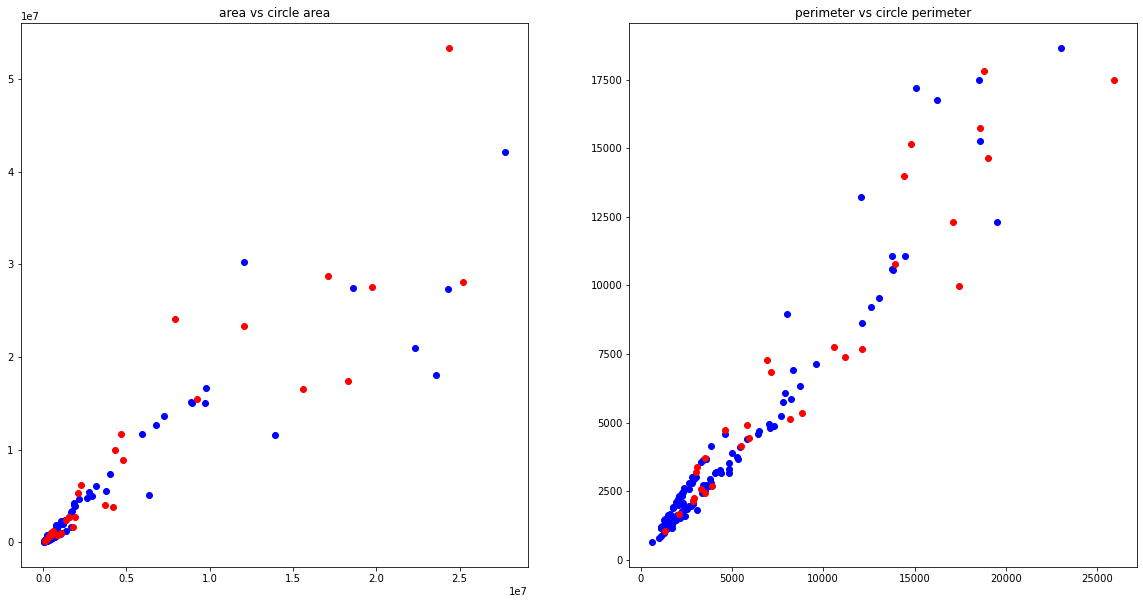

In [15]:
mel = pred_df[pred_df['melanoma']==1.0]
clear = pred_df[pred_df['melanoma']==0.0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes = axes.flatten()

axes[0].scatter(clear['area'], clear['pred_area'], c='blue')
axes[0].scatter(mel['area'], mel['pred_area'], c='red')

axes[1].scatter(clear['peri'], clear['pred_peri'], c='blue')
axes[1].scatter(mel['peri'], mel['pred_peri'], c='red')

axes[0].set_title('area vs circle area')
axes[1].set_title('perimeter vs circle perimeter');
